In [1]:
"""Missing in time series."""

'Missing in time series.'

# Пропуски во временных рядах

In [ ]:
import io
import os
import random

import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.interpolate import CubicSpline

# импортируем функцию для расчета RMSE
from sklearn.metrics import root_mean_squared_error

In [3]:
sns.set(rc={"figure.figsize": (10, 6)})

### Подготовка данных

In [ ]:
passengers_csv_url = os.environ.get("PASSENGERS_CSV_URL", "")
births_csv_url = os.environ.get("BIRTHS_CSV_URL", "")
response_passengers = requests.get(passengers_csv_url)
response_births = requests.get(births_csv_url)

# импортируем датасеты
passengers = pd.read_csv(io.BytesIO(response_passengers.content))
births = pd.read_csv(io.BytesIO(response_births.content))

#### Добавление пропусков

In [ ]:
random.seed(1)

# переименуем столбец #Passengers в reference
passengers.rename(columns={"#Passengers": "reference"}, inplace=True)

# сделаем две копии этого столбца с названиями target и missing
passengers["target"] = passengers.reference
passengers["missing"] = passengers.reference

# посчитаем количество наблюдений
n_samples = len(passengers)
# вычислим 20 процентов от этого числа,
# это будет количество пропусков
how_many = int(0.20 * n_samples)

# случайным образом выберем 20 процентов значений индекса
mask_target = random.sample(list(passengers.index), how_many)
# и заполним их значением NaN в столбце target
passengers.iloc[mask_target, 2] = np.nan

# найдем оставшиеся значения индекса
mask_missing = list(set(passengers.index) - set(mask_target))
# сделаем их NaN и поместим в столбец missing
passengers.iloc[mask_missing, 3] = np.nan

# переведем столбец Month в формат datetime
passengers.index = pd.to_datetime(passengers.Month)
passengers.drop(columns=["Month"], inplace=True)

In [6]:
# посчитаем количество пропусков в каждом столбце
passengers.isnull().sum()

reference      0
target        28
missing      116
dtype: int64

In [7]:
passengers.head(3)

,reference,target,missing
Month,,,
1949-01-01,112,NaN,112.0
1949-02-01,118,118.0,NaN
1949-03-01,132,NaN,132.0


In [ ]:
random.seed(1)

births.rename(columns={"Births": "reference"}, inplace=True)
births["target"] = births.reference
births["missing"] = births.reference

n_samples = len(births)
how_many = int(0.15 * n_samples)

mask_target = random.sample(list(births.index), how_many)
births.iloc[mask_target, 2] = np.nan

mask_missing = list(set(births.index) - set(mask_target))
births.iloc[mask_missing, 3] = np.nan

births.index = pd.to_datetime(births.Date)
births.drop(columns=["Date"], inplace=True)

In [9]:
births.isnull().sum()

reference      0
target        54
missing      311
dtype: int64

In [10]:
births.head(3)

,reference,target,missing
Date,,,
1959-01-01,35,35.0,NaN
1959-01-02,32,NaN,32.0
1959-01-03,30,30.0,NaN


#### Визуализация пропусков

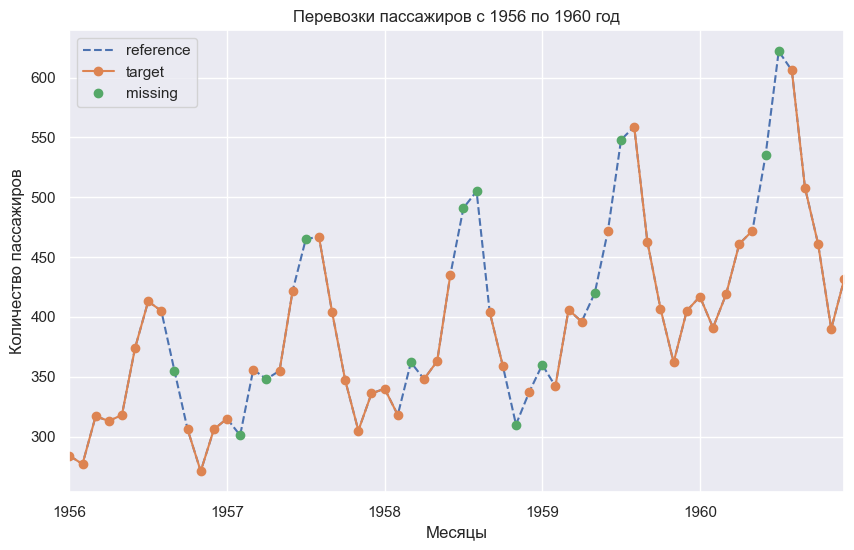

In [11]:
# сократим временной ряд
passengers = passengers.loc["1956-01":"1960-12"]  # type: ignore[misc]

ax = passengers.plot(style=["--", "o-", "o"])
ax.set(
    title="Перевозки пассажиров с 1956 по 1960 год",
    xlabel="Месяцы",
    ylabel="Количество пассажиров",
);

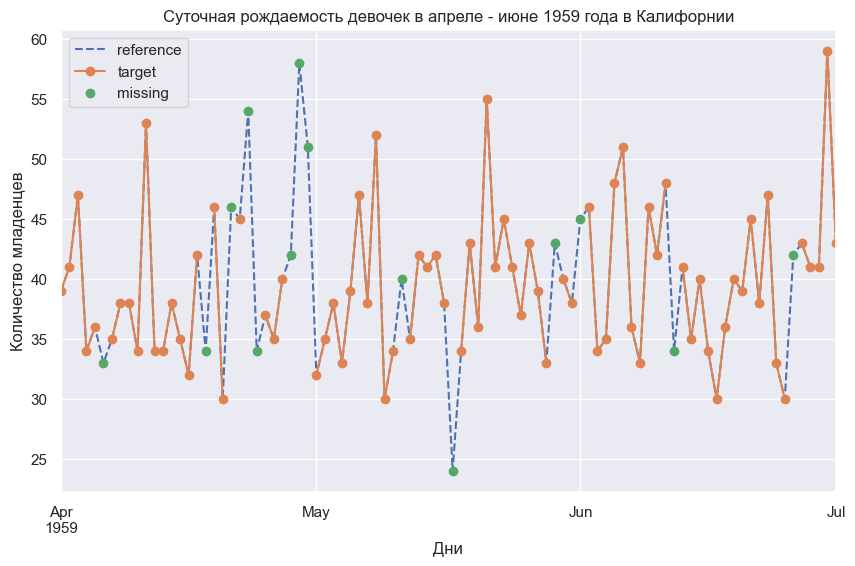

In [12]:
# данные о рождаемости также сократим
births = births.loc["1959-04-01":"1959-07-01"]  # type: ignore[misc]

ax = births.plot(style=["--", "o-", "o"])
ax.set(
    title="Суточная рождаемость девочек в апреле - июне 1959 года в Калифорнии",
    xlabel="Дни",
    ylabel="Количество младенцев",
);

### Заполнение средним и медианой

In [13]:
# передадим в метод .fillna() среднее арифметическое и медиану
passengers = passengers.assign(
    FillMean=passengers.target.fillna(passengers.target.mean())
)
passengers = passengers.assign(
    FillMedian=passengers.target.fillna(passengers.target.median())
)

In [14]:
# сделаем то же самое для данных о рождаемости
births = births.assign(FillMean=births.target.fillna(births.target.mean()))
births = births.assign(FillMedian=births.target.fillna(births.target.median()))

### Заполнение предыдущим и последующим значениями

In [15]:
# заполним пропуски предыдущим значением
passengers = passengers.assign(FFill=passengers.target.ffill())
births = births.assign(FFill=births.target.ffill())

In [16]:
# заполним пропуски последующим значением
passengers = passengers.assign(BFill=passengers.target.bfill())
births = births.assign(BFill=births.target.bfill())

### Заполнение скользящим средним и медианой

In [17]:
# рассчитаем скользящее среднее и медиану для данных о пассажирах
passengers = passengers.assign(
    RollingMean=passengers.target.fillna(
        passengers.target.rolling(window=5, min_periods=1).mean()
    )
)

passengers = passengers.assign(
    RollingMedian=passengers.target.fillna(
        passengers.target.rolling(window=5, min_periods=1).median()
    )
)

In [18]:
# рассчитаем скользящее среднее и медиану для данных о рождаемости
births = births.assign(
    RollingMean=births.target.fillna(
        births.target.rolling(window=5, min_periods=1).mean()
    )
)

births = births.assign(
    RollingMedian=births.target.fillna(
        births.target.rolling(window=5, min_periods=1).median()
    )
)

### Интерполяция

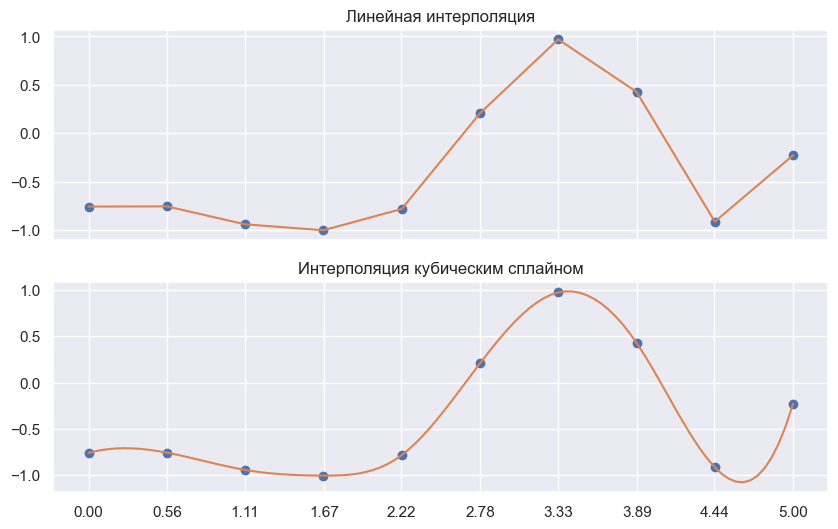

In [19]:
# зададим 10 точек (узлов) в интервале от 0 до 5
a_var = 10
b_var = np.linspace(0, 5, a_var)
c_var = np.sin(b_var**2 / 3 + 4) + 0.1 * np.random.randn(a_var)

# выведем на графике узлы
# и созданные по ним интерполирующие функции
xnew = np.linspace(0, 5, 100)

# вычислим линейный интерполянт
f1 = np.interp(xnew, b_var, c_var)
# и кубический сплайн
f3 = CubicSpline(b_var, c_var)

d_var, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(b_var, c_var, "o", xnew, f1, "-")
ax[0].set(title="Линейная интерполяция")
ax[1].plot(b_var, c_var, "o", xnew, f3(xnew), "-")
ax[1].set(title="Интерполяция кубическим сплайном", xticks=np.round(b_var, 2))

plt.show()

In [20]:
# создадим список из названий методов интерполяции,
# которые передадим в .interpolate()
methods = ["linear", "polynomial", "quadratic", "cubic", "spline"]

In [21]:
# применим каждый из методов к данным о пассажирах
for e_var in methods:
    if e_var == "polynomial":
        # для полиномиальной интерполяции нужно указать степень полинома
        # (пока поддерживаются только нечетные степени)
        passengers[e_var] = passengers.target.interpolate(
            method=e_var,
            order=3,  # type: ignore[call-overload]
        )
    elif e_var == "spline":
        # для сплайна порядок должен быть 1 <= k <= 5
        passengers[e_var] = passengers.target.interpolate(
            method=e_var,
            order=5,  # type: ignore[call-overload]
        )
    else:
        passengers[e_var] = passengers.target.interpolate(
            method=e_var,  # type: ignore[call-overload]
        )

In [29]:
# сделаем то же самое с данными о рождаемости
for e_var in methods:
    if e_var == "polynomial":
        births[e_var] = births.target.interpolate(
            method=e_var,
            order=3,  # type: ignore[call-overload]
        )
    elif e_var == "spline":
        # для сплайна порядок должен быть 1 <= k <= 5
        births[e_var] = births.target.interpolate(
            method=e_var,
            order=5,  # type: ignore[call-overload]
        )
    else:
        births[e_var] = births.target.interpolate(
            method=e_var,  # type: ignore[call-overload]
        )

### Сравнение методов

In [ ]:
# fmt: off
# напишем функцию для сравнения методов
def compare_methods(df: DataFrame) -> DataFrame:
    """Compare interpolation methods by RMSE error magnitude."""
    # в цикле list comprehension будем брать по одному столбцу
    # (итерируя по названиям столбцов)
    # и рассчитывать корень среднеквадратической ошибки    
    rmse_list: list[tuple[str, float]] = [
        (
            method,
            float(
                np.round(
                    root_mean_squared_error(df.reference, df[method]),
                    2,
                )
            ),
        )
        for method in df.columns[3:]
    ]

    results: DataFrame = pd.DataFrame(rmse_list, columns=["Method", "RMSE"])
    results.sort_values(by="RMSE", inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results
# fmt: on

In [25]:
# сравним методы для данных о пассажирах
passengers_results = compare_methods(passengers)
passengers_results

,Method,RMSE
0,spline,12.29
1,polynomial,12.47
2,cubic,12.47
3,quadratic,12.72
4,linear,19.26
5,BFill,23.32
6,FFill,28.96
7,RollingMean,40.44
8,RollingMedian,43.35
9,FillMedian,49.79


In [26]:
# и рождаемости
births_results = compare_methods(births)
births_results

,Method,RMSE
0,FillMean,3.55
1,FillMedian,3.65
2,RollingMedian,3.81
3,RollingMean,3.89
4,FFill,4.3
5,BFill,4.39


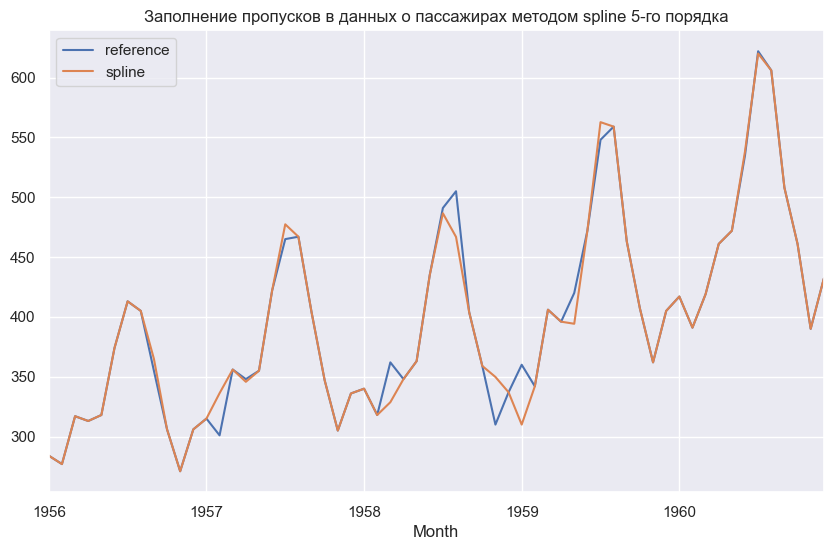

In [27]:
# выведем лидера по точности заполнения пропусков в данных о пассажирах
passengers[["reference", "spline"]].plot()
plt.title("Заполнение пропусков в данных о пассажирах методом spline 5-го порядка");

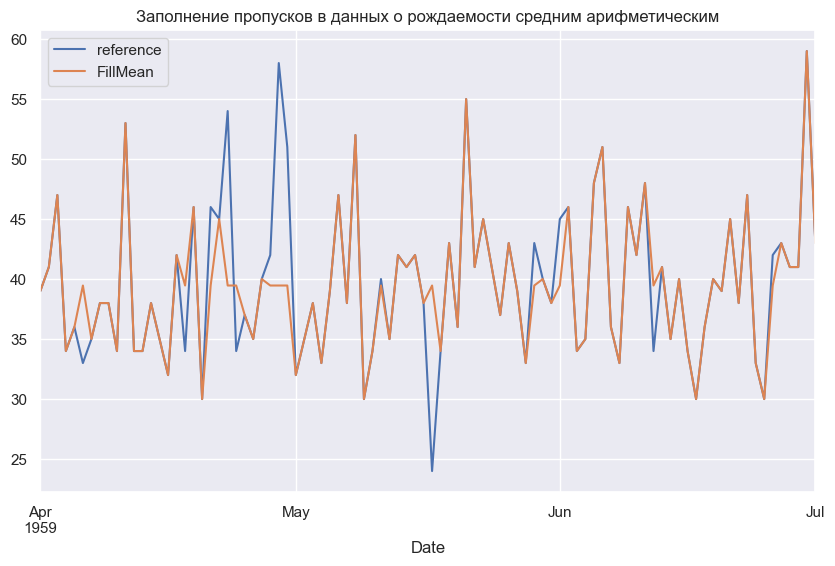

In [28]:
# сделаем то же самое для данных о рождаемости
births[["reference", "FillMean"]].plot()
plt.title("Заполнение пропусков в данных о рождаемости средним арифметическим");